In [78]:
from qiskit import *
import numpy as np



In [79]:
#load adjacency matrix
A = np.load(file="adj.coo.npy")
adj_matrix = np.zeros((2708,2708))
#print(len(A))
for i in range(2708):
    a = int(A[0][i])
    b = int(A[1][i])
    #print(a)
    #print(b)
    adj_matrix[a][b] = 1
    adj_matrix[b][a] = 1


In [80]:
#load label
y = np.load(file="y_label.npy")

print(y)
print(y.shape)

[3 4 4 ... 3 3 3]
(2708,)


In [81]:
#load feature
feature = np.load(file="feature.npy")
print(len(feature))
print([len(a) for a in feature])

2708
[1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433

In [82]:
# N: number of nodes, d:number of feature
def get_data(N,d):
    #adj = np.asarray(np.load(file="adj.coo.npy"))
    adj = adj_matrix
    y = np.asarray(np.load(file="y_label.npy"))
    feature_all = np.asarray(np.load(file="feature.npy"))
    
    count = 0
    feature = np.zeros((N,d))
    remove = []
    while(count != N):
        print(count)
        print(feature_all.shape)
        L2_norm = np.linalg.norm(feature_all[count,0:d],2)
#L2_norm != 0 and 
        if L2_norm != 0 and (y[count] == 5 or y[count] == 6): # load the node with label 5 or 6 and its feature is non-zero
            feature[count,0:d] = feature_all[count,0:d] / L2_norm
            count = count + 1
        else:
            remove.append(count)
            #print(count)
            y = np.delete(y,count)
            adj = np.delete(adj,count,0)
            adj = np.delete(adj,count,1)
            feature_all = np.delete(feature_all,count,0)
            #print(feature_all.shape)
    adj = adj[0:N,0:N]
    
    feature = feature[0:N,0:d]
    #print(feature.shape)
    y = y[0:N]
    #print(remove)
    #print(count)
    print(adj.shape)
    print(feature.shape)
    print(y.shape)
    return adj, feature, y

In [83]:
# N: number of nodes, d:number of feature
N = 32
d = 128
adj, feature, label = get_data(N,d)


0
(2708, 1433)
0
(2707, 1433)
0
(2706, 1433)
0
(2705, 1433)
0
(2704, 1433)
0
(2703, 1433)
0
(2702, 1433)
0
(2701, 1433)
0
(2700, 1433)
0
(2699, 1433)
0
(2698, 1433)
0
(2697, 1433)
0
(2696, 1433)
0
(2695, 1433)
0
(2694, 1433)
0
(2693, 1433)
0
(2692, 1433)
0
(2691, 1433)
0
(2690, 1433)
0
(2689, 1433)
0
(2688, 1433)
1
(2688, 1433)
1
(2687, 1433)
1
(2686, 1433)
2
(2686, 1433)
2
(2685, 1433)
2
(2684, 1433)
3
(2684, 1433)
3
(2683, 1433)
3
(2682, 1433)
3
(2681, 1433)
3
(2680, 1433)
4
(2680, 1433)
4
(2679, 1433)
4
(2678, 1433)
4
(2677, 1433)
4
(2676, 1433)
4
(2675, 1433)
5
(2675, 1433)
5
(2674, 1433)
5
(2673, 1433)
5
(2672, 1433)
6
(2672, 1433)
7
(2672, 1433)
7
(2671, 1433)
7
(2670, 1433)
7
(2669, 1433)
7
(2668, 1433)
8
(2668, 1433)
8
(2667, 1433)
8
(2666, 1433)
9
(2666, 1433)
9
(2665, 1433)
9
(2664, 1433)
9
(2663, 1433)
9
(2662, 1433)
9
(2661, 1433)
10
(2661, 1433)
10
(2660, 1433)
10
(2659, 1433)
10
(2658, 1433)
10
(2657, 1433)
10
(2656, 1433)
10
(2655, 1433)
10
(2654, 1433)
10
(2653, 1433)
1

In [84]:
print(label)

[5 6 6 6 5 6 6 5 5 6 5 6 5 5 6 6 6 5 6 5 6 5 5 5 6 5 6 5 6 6 5 6]


In [85]:
#print the max dimension of feature among the nodes
count = 0
for i in range(N):
    temp = np.count_nonzero(feature[i,:])
    if temp > count:
        count = temp
print(count)

6


In [86]:
#np.save("feature_temp", feature)
#np.save("label_preprocess",label)

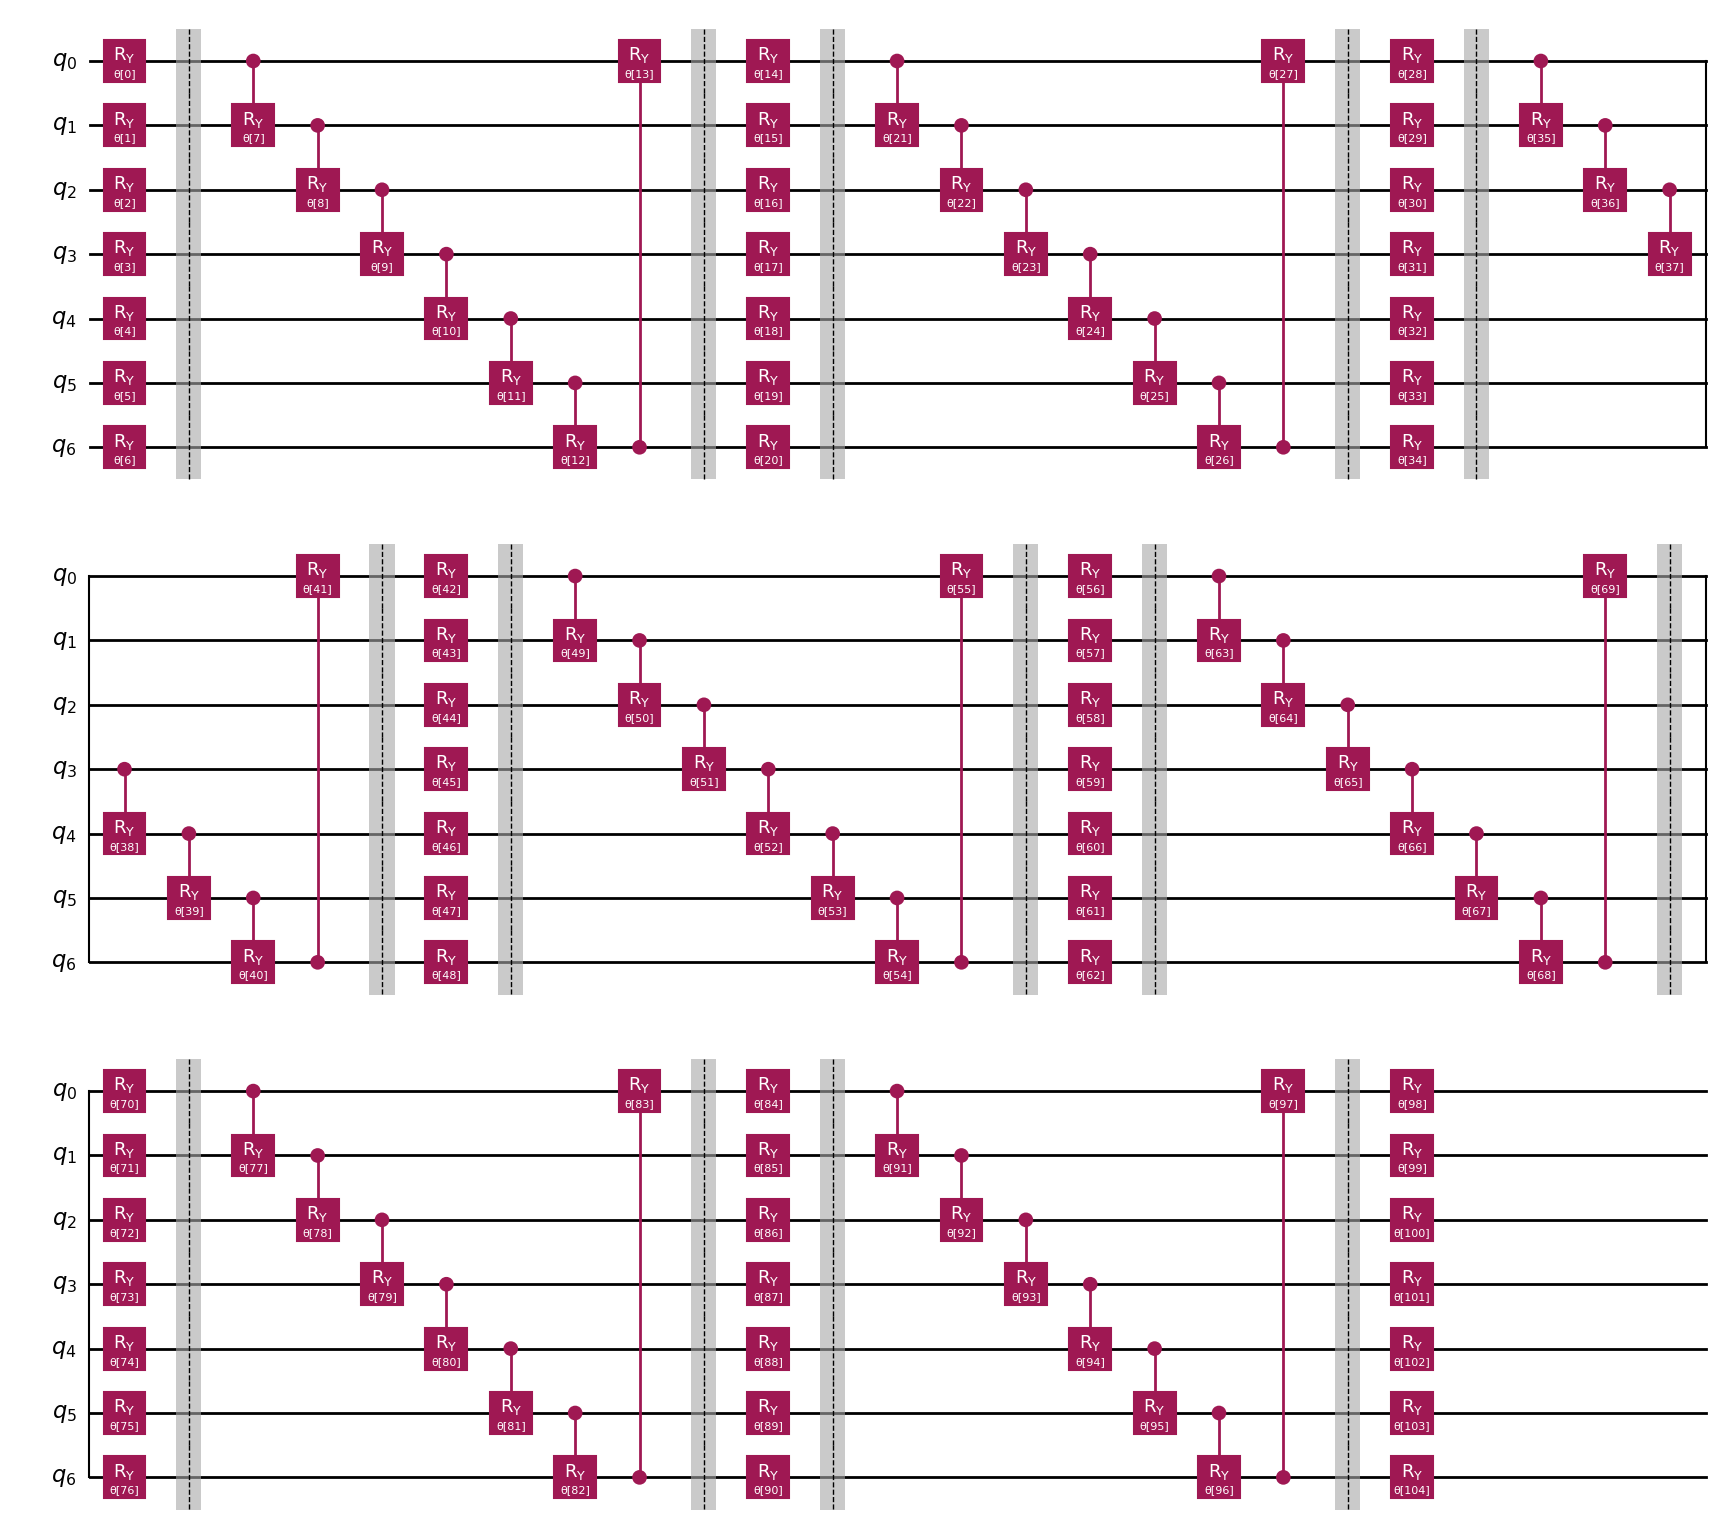

In [87]:
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate, CRYGate, RYGate
from qiskit.circuit import Parameter
#define pqc for feature extraction
n = int(np.log2(d))
entangle_list = []
for i in range(n-1):
    entangle_list.append([i,i+1])
entangle_list.append([n-1,0])
theta = Parameter("θ")
pqc = NLocal(
    num_qubits=n,
    rotation_blocks=[RYGate(theta)],
    entanglement_blocks=CRYGate(theta),
    entanglement= entangle_list,
    reps=7, #layer can be modified to 7
    insert_barriers=True,
)
pqc.decompose().draw("mpl")

In [88]:
#data encoding + vqc, this is just a demo (not used in later implementation)
from qiskit_machine_learning.circuit.library import RawFeatureVector
num_latent = 1
num_trash = n-num_latent

circuits = []
count = 0
for i in range(N):
    fm = RawFeatureVector(2 ** (num_latent + num_trash))
    
   
    if np.linalg.norm(feature[i,:],2) != 0:
        count = count + 1
        state = feature[i,:]
        fm.assign_parameters(state)
        
        
        ansatz = fm.compose(pqc)
        circuits.append(ansatz)
        #display(qc.draw("mpl"))
        #display(ansatz.draw("mpl"))
        #print(i)

print(count)

32


In [89]:
#data encoding
def ansatz(num_latent, num_trash):
    fm = RawFeatureVector(2 ** (num_latent + num_trash))
    #fm = fm.assign_parameters(state)  
    return fm

In [90]:
from qiskit_machine_learning.neural_networks import SamplerQNN
import matplotlib.pyplot as plt
from qiskit_algorithms.optimizers import COBYLA,GradientDescent
from qiskit_algorithms.utils import algorithm_globals
from IPython.display import clear_output
import time
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

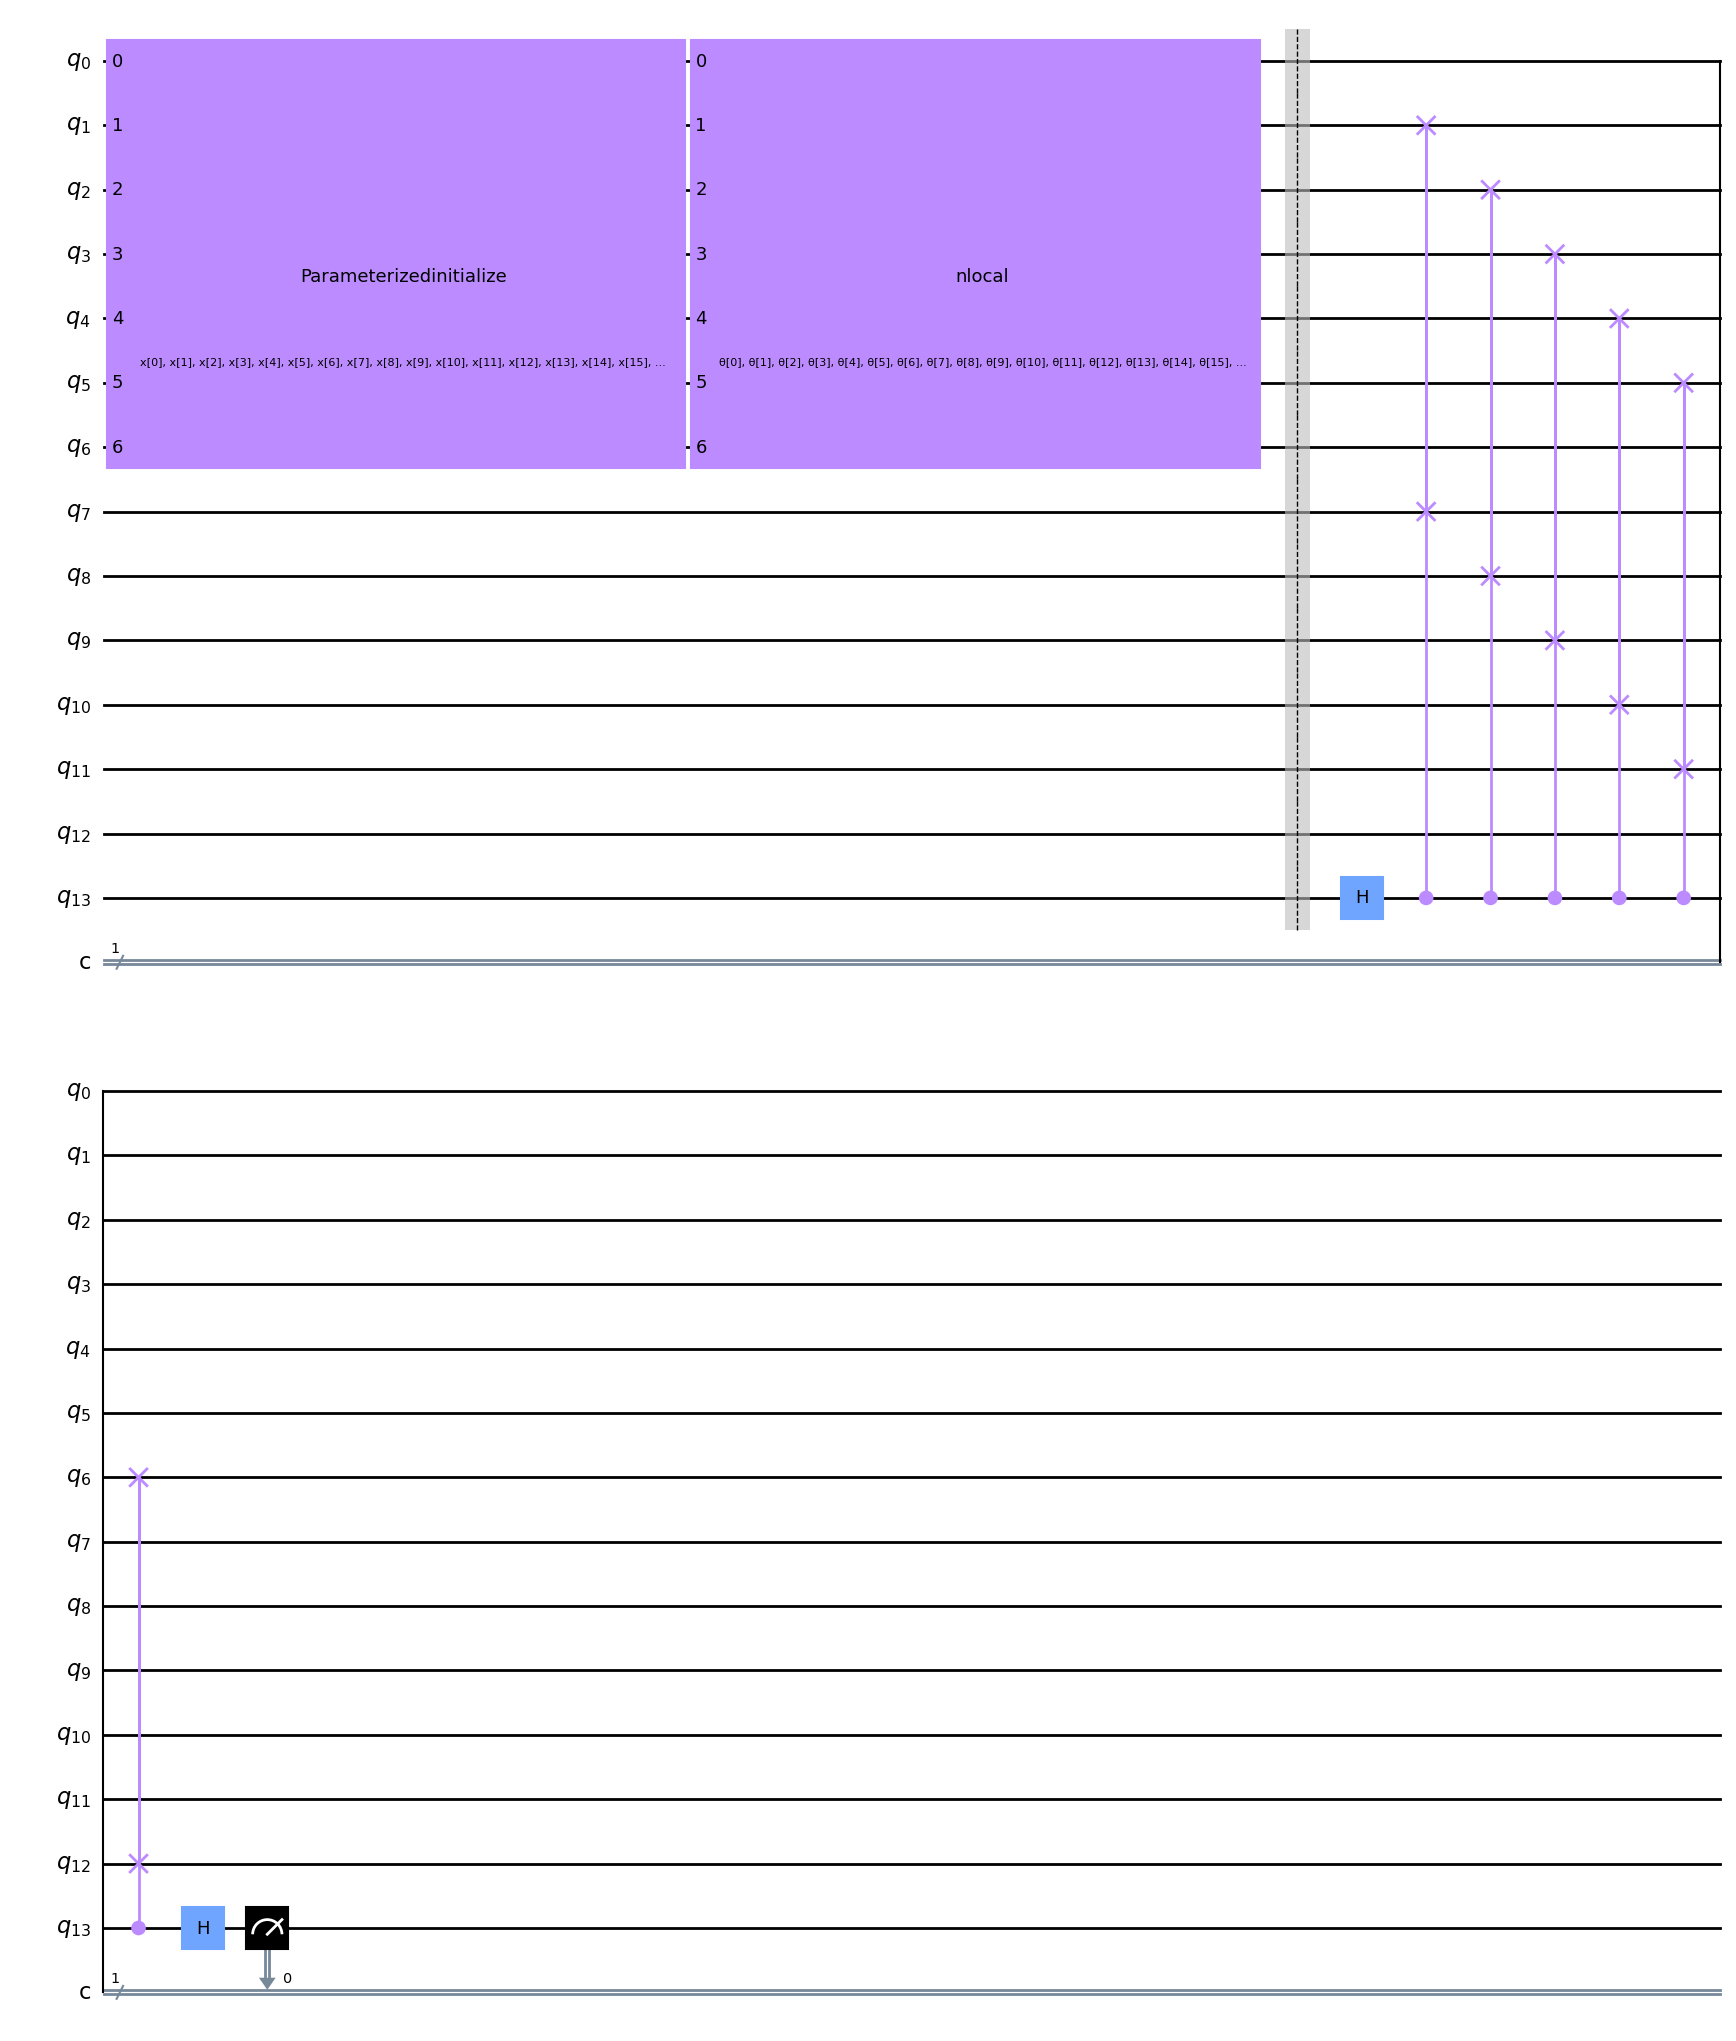

'\ncircuits.append(qc) \n\nseed = 170\nalgorithm_globals.random_seed = seed\n\nprint()\n\ndevices = AerSimulator(device="GPU").available_devices()\nprint(devices)\nmethods = AerSimulator(device="GPU").available_methods()\nprint(methods)\n'

In [91]:
#auto encoder of feature extraction
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    
    #circuit.compose(ansatz(num_latent, num_trash,state), range(0, num_latent + num_trash), inplace=True)

    circuit = circuit.compose(pqc)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit

def identity_interpret(x):
    return x

num_latent = 1
num_trash = n-num_latent

circuits = []
count = 0
result = []
output = []
feature_extract = []



ae = auto_encoder_circuit(num_latent, num_trash)
fm = ansatz(num_latent, num_trash)


qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm)
qc = qc.compose(ae)
display(qc.draw(output="mpl", style="clifford"))

'''
circuits.append(qc) 

seed = 170
algorithm_globals.random_seed = seed

print()

devices = AerSimulator(device="GPU").available_devices()
print(devices)
methods = AerSimulator(device="GPU").available_methods()
print(methods)
'''




In [92]:
'''
method = "automatic"
device = "CPU"
if "GPU" in devices and "tensor_network" in methods:
    device = "GPU"

noisy_sampler = Sampler(
    backend_options={
        "method": method,
        "device": device,
        "noise_model": noise_bit_flip,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed}
)
'''
qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [93]:
#Wrap functon by multi-process
#cu stat-vector

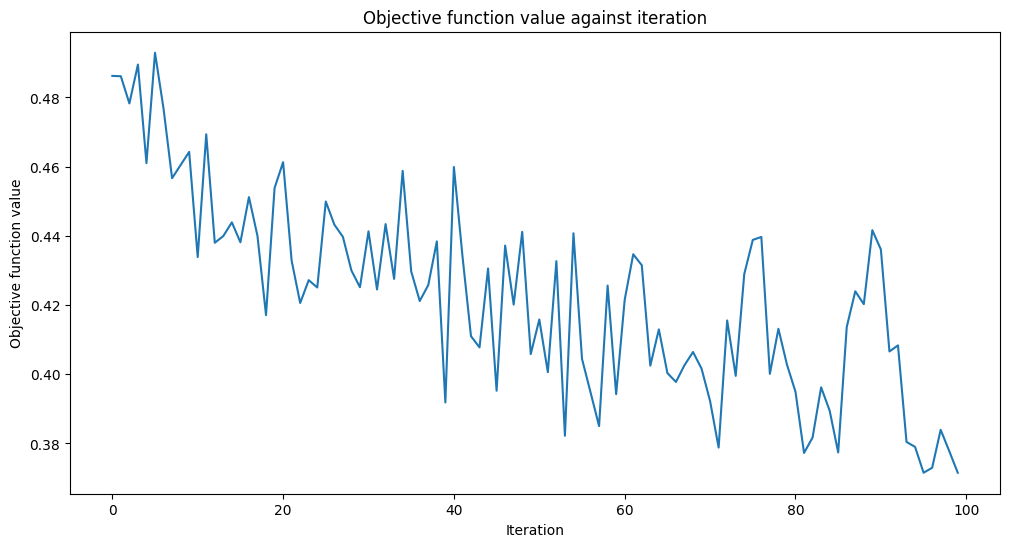

Fit in 11.77 seconds
Fidelity of our Output State with our Input State:  0.506852650901636
[ 6.30151008e-03+0.j  3.60966278e-01+0.j -2.94375308e-02+0.j
 -4.51714344e-02+0.j -3.49595523e-02+0.j -8.93385259e-02+0.j
  1.55541350e-02+0.j -6.77350385e-03+0.j  7.66162053e-02+0.j
 -1.31860325e-01+0.j -2.75202062e-02+0.j -3.60835580e-02+0.j
 -7.81968170e-02+0.j  3.66282597e-01+0.j -3.61570355e-02+0.j
  5.87633027e-02+0.j -5.50573558e-02+0.j  2.62336690e-01+0.j
 -3.39119978e-02+0.j  1.38355650e-01+0.j -4.71812627e-03+0.j
  1.79474506e-02+0.j  2.20675687e-02+0.j  4.02984515e-03+0.j
 -5.31229674e-02+0.j  3.93960595e-02+0.j  3.10790716e-03+0.j
 -2.08067752e-02+0.j  4.10594137e-02+0.j -3.07584668e-01+0.j
  3.20141325e-02+0.j  4.82636229e-02+0.j  5.50069967e-02+0.j
 -4.52808770e-02+0.j -9.85543691e-03+0.j -1.20778595e-01+0.j
 -1.66637701e-03+0.j -2.41920402e-02+0.j -2.19382267e-02+0.j
 -1.44891236e-02+0.j  3.40148852e-02+0.j -1.30817033e-01+0.j
  6.28661093e-03+0.j  6.33405280e-02+0.j  9.33454801e-0

In [94]:
for i in range(N):
    def cost_func_domain(params_values):
        probabilities = qnn.forward(feature[i,:], params_values)
        # we pick a probability of getting 1 as the output of the network
        cost = np.sum(probabilities[:, 1])

        # plotting part
        clear_output(wait=True)
        objective_func_vals.append(cost)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(objective_func_vals)), objective_func_vals)
        plt.show()
        return cost
    opt = COBYLA(maxiter=100)
    #opt = GradientDescent(maxiter = 100)
    initial_point = algorithm_globals.random.random(ae.num_parameters)

    objective_func_vals = []
    # make the plot nicer
    plt.rcParams["figure.figsize"] = (12, 6)

    start = time.time()
    opt_result = opt.minimize(cost_func_domain, initial_point)
    result.append(opt_result.x)
    elapsed = time.time() - start
    print(f"Fit in {elapsed:0.2f} seconds")

    test_qc = QuantumCircuit(num_latent + num_trash)
    test_qc = test_qc.compose(fm)
    test_qc = test_qc.compose(pqc)
    test_qc.barrier()
    for j in range(num_latent,n):
        test_qc.reset(j)
    test_qc.barrier()
    test_qc = test_qc.compose(pqc.inverse())


    original_qc = fm.assign_parameters(feature[i,:])
    original_sv = Statevector(original_qc).data

    param_values = np.concatenate((feature[i,:],opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_qc.save_density_matrix(qubits = list(range(0,num_latent)))
    output_qc.measure_all()

    simulator = AerSimulator()
    circ = transpile(output_qc, backend=simulator)
    job = simulator.run(circ)
    statevector = job.result().data()['density_matrix']
    feature_extract.append(statevector)

    fidelity = np.sqrt(np.dot(original_sv.conj(), output_sv) ** 2)
    print("Fidelity of our Output State with our Input State: ", fidelity.real) 
    print(output_sv)
    output.append(fidelity.real)

In [95]:
#print fidelity
print(output)

[0.22131221712480098, 0.18256760499921929, 0.6094349630562699, 0.4086349581040809, 0.6054435692822352, 0.48582766926154336, 0.36902209778112544, 0.07733112590825034, 0.4597757807131906, 0.24614818249849357, 0.41887648888835494, 0.16629786711036915, 0.12330545014673967, 0.26606093438574796, 0.45725423015520333, 0.24654054545522608, 0.4345645841000342, 0.12248355422348228, 0.4168905833095296, 0.5512779047803302, 0.25024811083860604, 0.48971764768801523, 0.3246194973938742, 0.0009819701458828962, 0.20669206585788708, 0.6248658014926641, 0.43226793115652556, 0.38731619605117923, 0.3715688913514828, 0.07419864454823506, 0.2659455890706406, 0.506852650901636]


In [96]:
print(feature_extract)

[DensityMatrix([[ 0.33716734+0.j, -0.07940031+0.j],
               [-0.07940031+0.j,  0.66283266+0.j]],
              dims=(2,)), DensityMatrix([[0.50140525+0.j, 0.01527235+0.j],
               [0.01527235+0.j, 0.49859475+0.j]],
              dims=(2,)), DensityMatrix([[ 0.32783573+0.j, -0.06483376+0.j],
               [-0.06483376+0.j,  0.67216427+0.j]],
              dims=(2,)), DensityMatrix([[0.47362232+0.j, 0.18282711+0.j],
               [0.18282711+0.j, 0.52637768+0.j]],
              dims=(2,)), DensityMatrix([[ 0.68014208+0.j, -0.07865521+0.j],
               [-0.07865521+0.j,  0.31985792+0.j]],
              dims=(2,)), DensityMatrix([[0.50037281+0.j, 0.06424374+0.j],
               [0.06424374+0.j, 0.49962719+0.j]],
              dims=(2,)), DensityMatrix([[ 0.39368663+0.j, -0.1292845 +0.j],
               [-0.1292845 +0.j,  0.60631337+0.j]],
              dims=(2,)), DensityMatrix([[0.55475337+0.j, 0.05855092+0.j],
               [0.05855092+0.j, 0.44524663+0.j]],
         

In [97]:
new_feature = np.zeros((N,np.power(2,num_latent)))
for i in range(len(feature_extract)):
    for j in range(np.power(2,num_latent)):
        new_feature[i,j] = feature_extract[i][j,j] #take the diagonal element as the new feature

print(new_feature)


[[0.33716734 0.66283266]
 [0.50140525 0.49859475]
 [0.32783573 0.67216427]
 [0.47362232 0.52637768]
 [0.68014208 0.31985792]
 [0.50037281 0.49962719]
 [0.39368663 0.60631337]
 [0.55475337 0.44524663]
 [0.29670508 0.70329492]
 [0.29980725 0.70019275]
 [0.56837974 0.43162026]
 [0.50679606 0.49320394]
 [0.52102902 0.47897098]
 [0.67888328 0.32111672]
 [0.58881837 0.41118163]
 [0.64661925 0.35338075]
 [0.33767624 0.66232376]
 [0.53023073 0.46976927]
 [0.16150128 0.83849872]
 [0.80192493 0.19807507]
 [0.50039208 0.49960792]
 [0.73686183 0.26313817]
 [0.47506593 0.52493407]
 [0.66087558 0.33912442]
 [0.59847908 0.40152092]
 [0.65978978 0.34021022]
 [0.61037536 0.38962464]
 [0.40982401 0.59017599]
 [0.62150117 0.37849883]
 [0.51269514 0.48730486]
 [0.47644736 0.52355264]
 [0.15616383 0.84383617]]


/var/folders/jl/ktm0_prs0nq3srvwggw_4ssc0000gn/T/ipykernel_88164/2078970864.py:4: DeprecationWarning: The return type of saved density matrices has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.DensityMatrix` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  new_feature[i,j] = feature_extract[i][j,j] #take the diagonal element as the new feature
/var/folders/jl/ktm0_prs0nq3srvwggw_4ssc0000gn/T/ipykernel_88164/2078970864.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  new_feature[i,j] = feature_extract[i][j,j] #take the diagonal element as the new feature


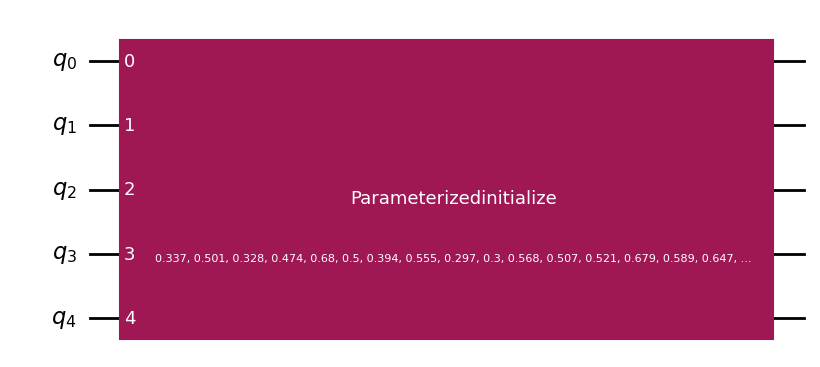

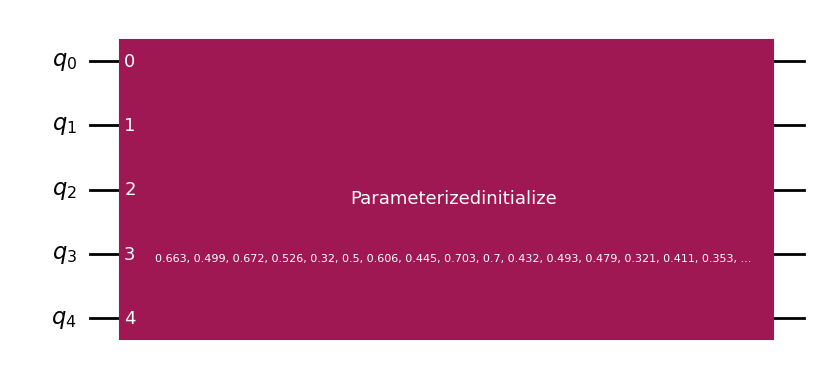

In [98]:
# encode one feature for N nodes in a circuit
feature_circ = []
for i in range(np.power(2,num_latent)):
    #qc = QuantumCircuit(np.log2(N))
    fm = RawFeatureVector(2 ** (np.log2(N)))
    fm = fm.assign_parameters(np.transpose(new_feature[:,i]))
    #qc.compose(fm)
    feature_circ.append(fm)
    display(fm.draw("mpl"))



In [99]:
from qiskit import *
import qiskit.quantum_info as qi
import numpy as np
from numpy import pi, sin, cos, sqrt, exp
import math
import graph_qc

In [100]:
#print(adj)
#np.save("adj_temp", adj)

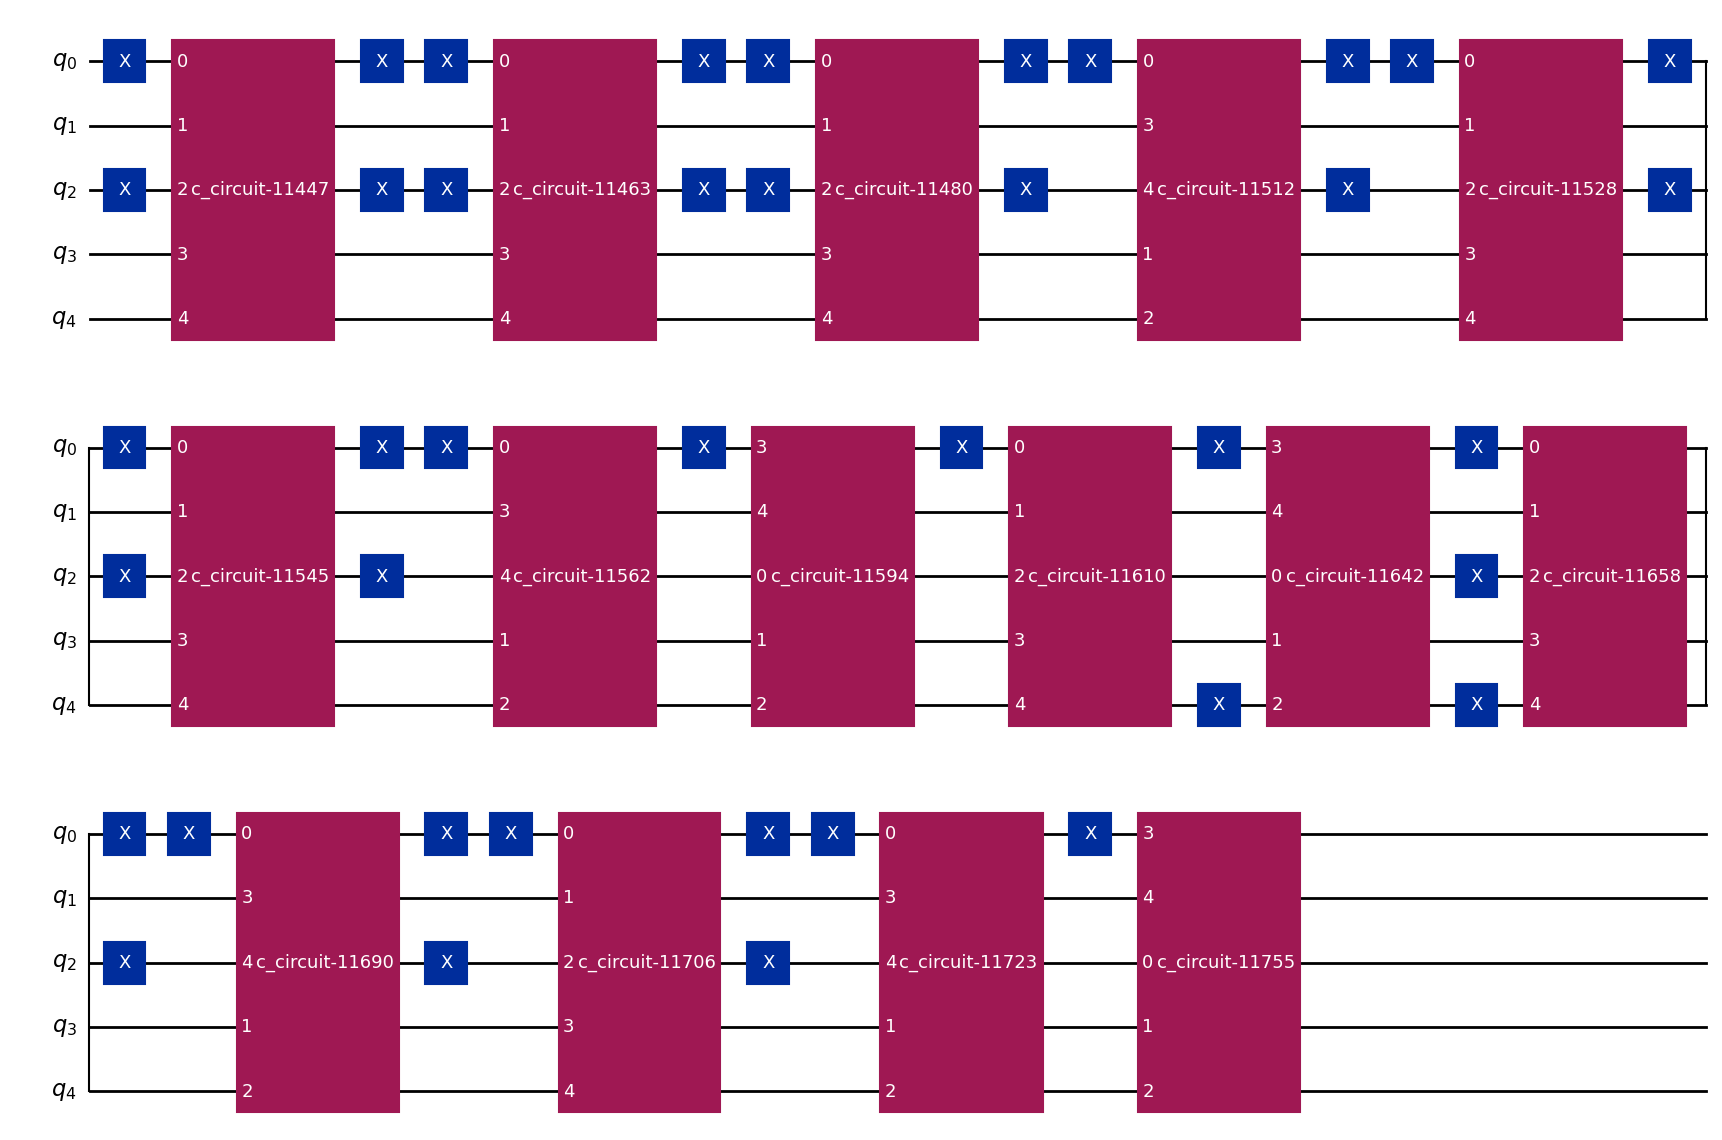

In [101]:
#use givens rotation for graph structure embedding

givens = QuantumCircuit(np.log2(N))

for i in range(0,N):
    for j in range(i+1,N):
        if adj[i][j] == 1.0:
            
            circuit, stack = graph_qc.transition(i,j,int(np.log2(N)))
            #display(circuit.draw("mpl"))
            givens = givens.compose(circuit,qubits = list(range(0,int(np.log2(N)))))

givens.decompose().draw("mpl")




In [102]:
#print(adj)
#np.save("adj_preprocess" , adj)

In [103]:
#check the total number of edges
count = 0
for i in range(N):
    count = count + np.count_nonzero(adj[i,:])
print(count/2)

6.0


In [104]:
print(givens.depth())
#print(givens.parameters)

15


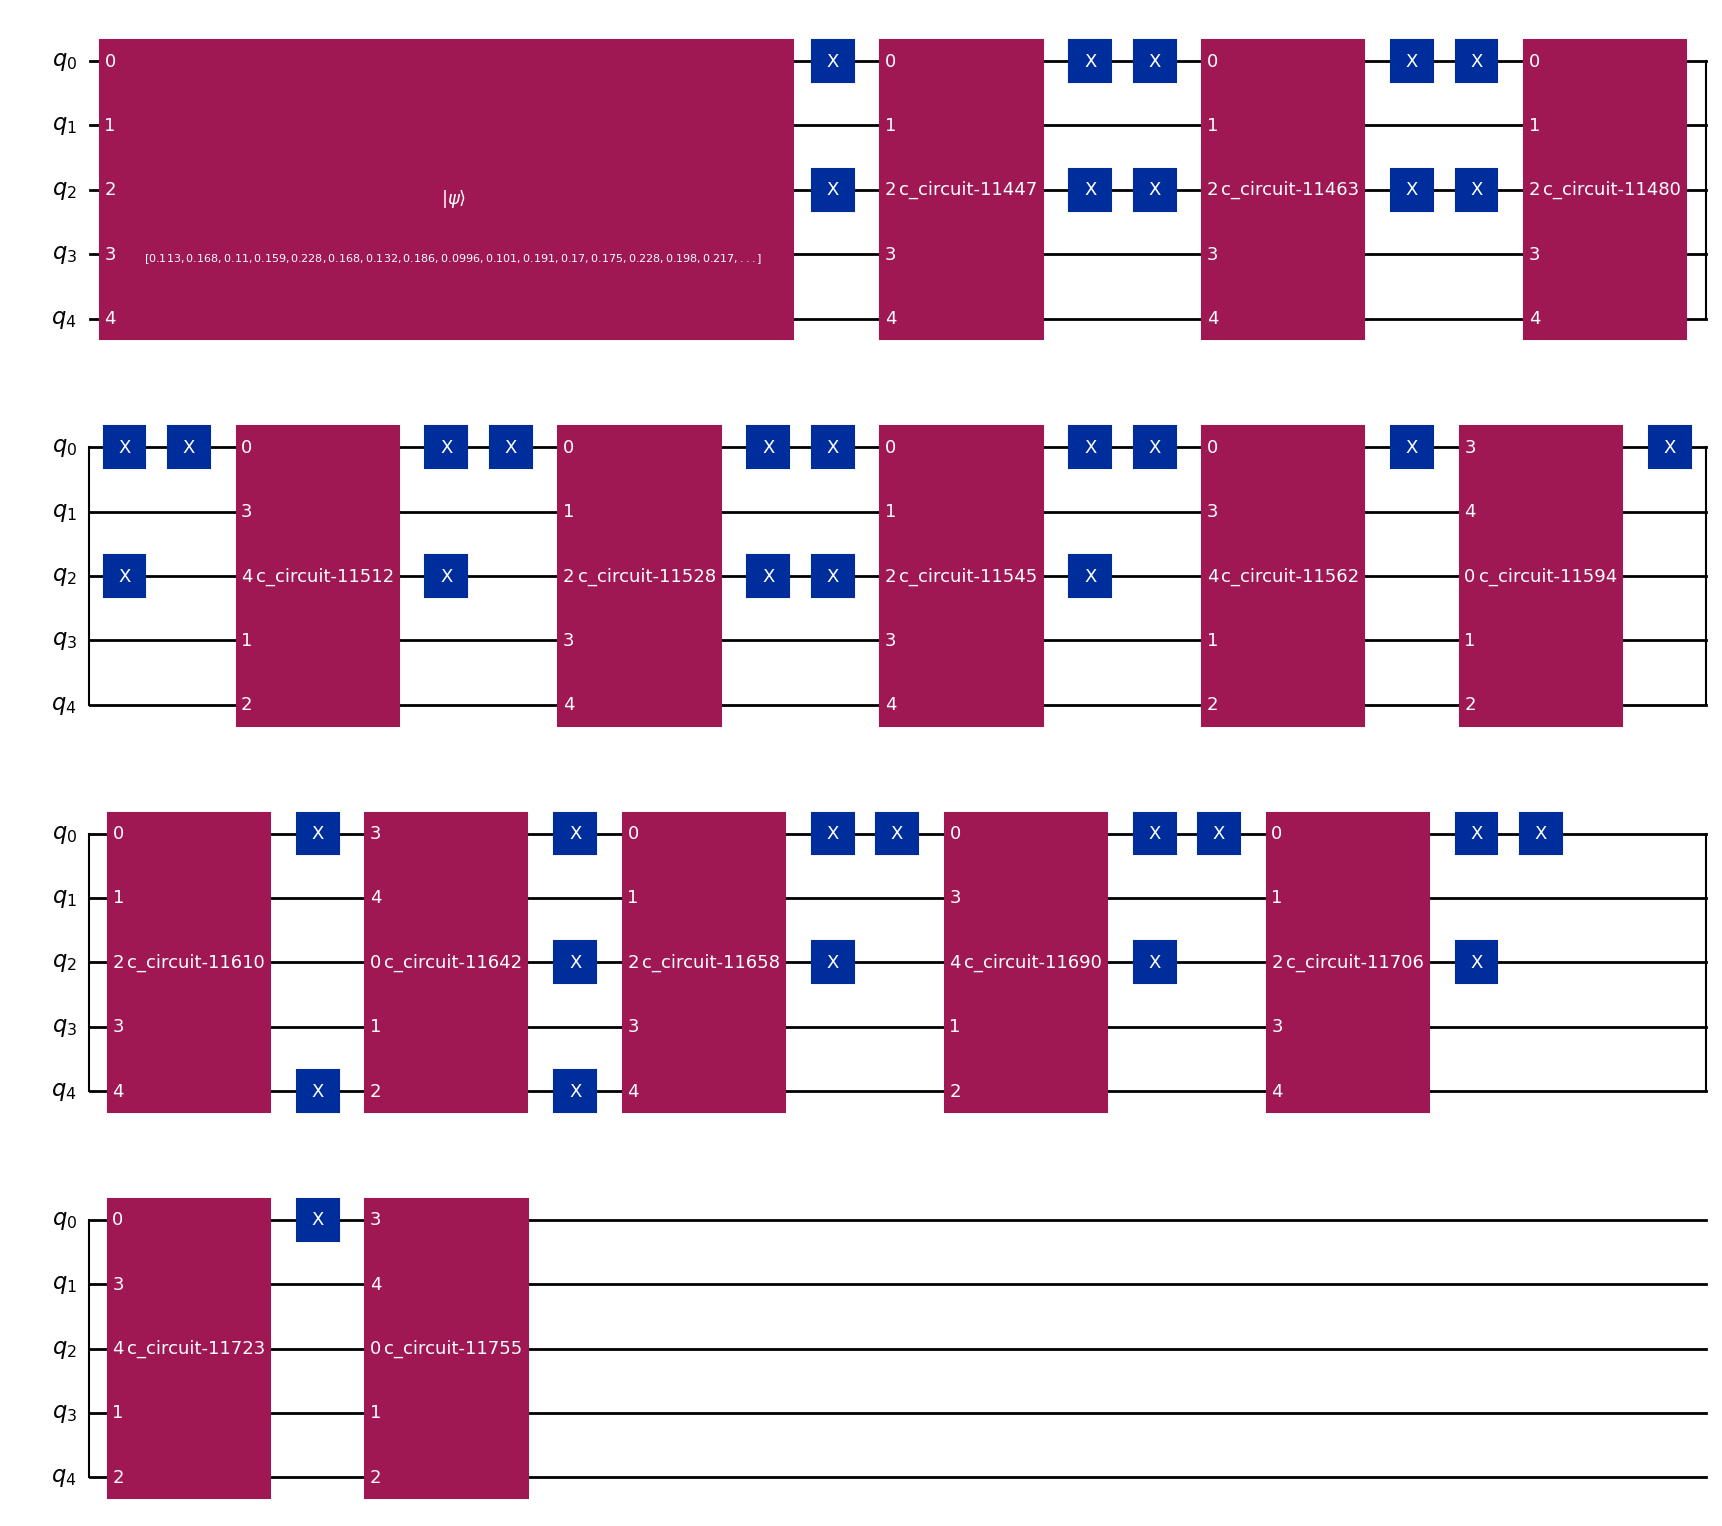

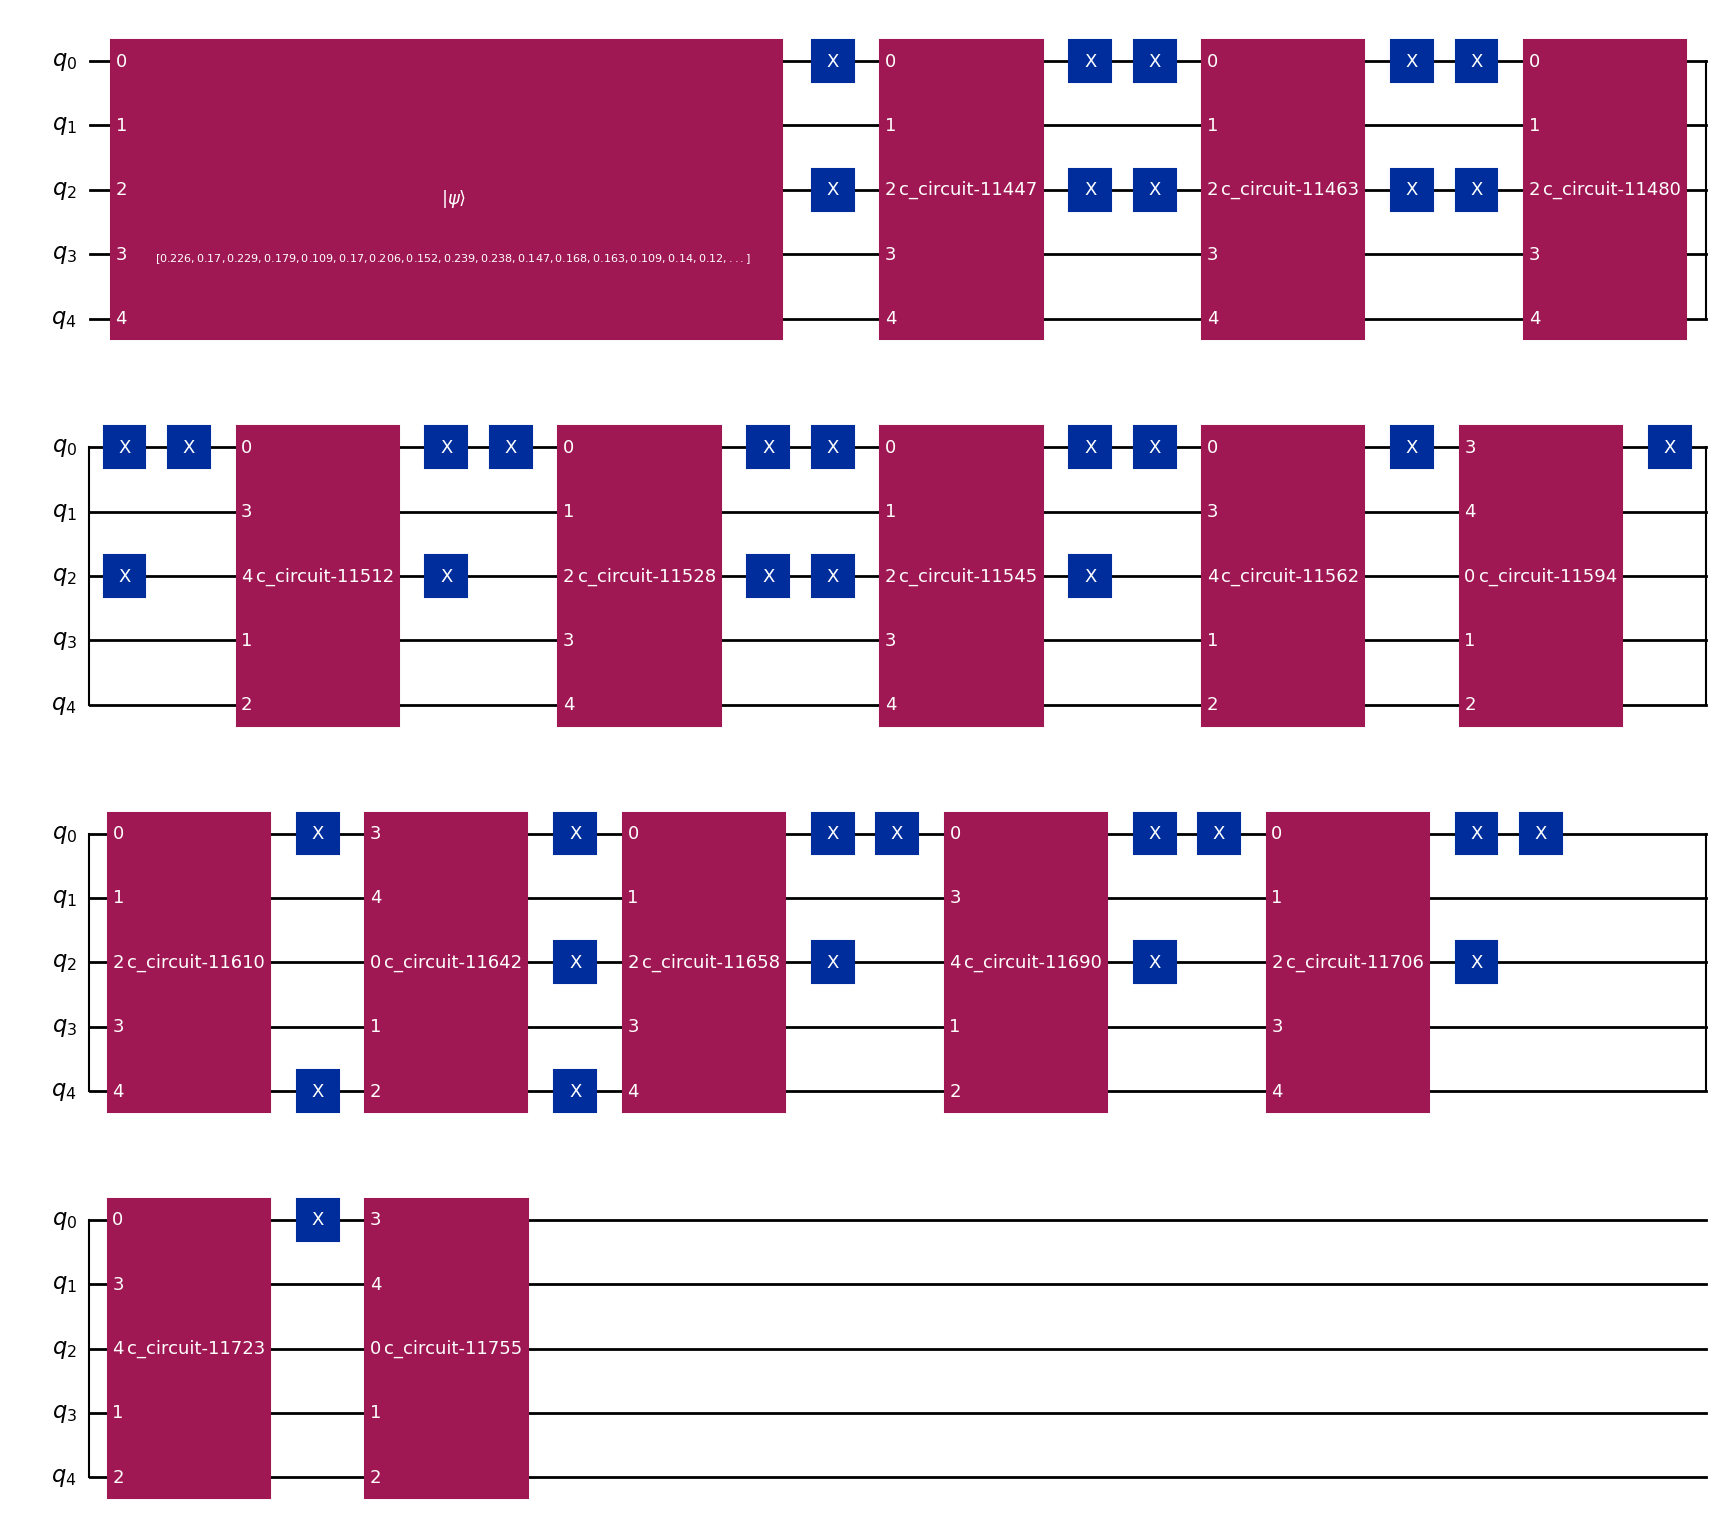

In [105]:
final_circ =[]
for circ in feature_circ:
    circ = circ.compose(givens)
    final_circ.append(circ)
    display(circ.decompose().draw("mpl"))

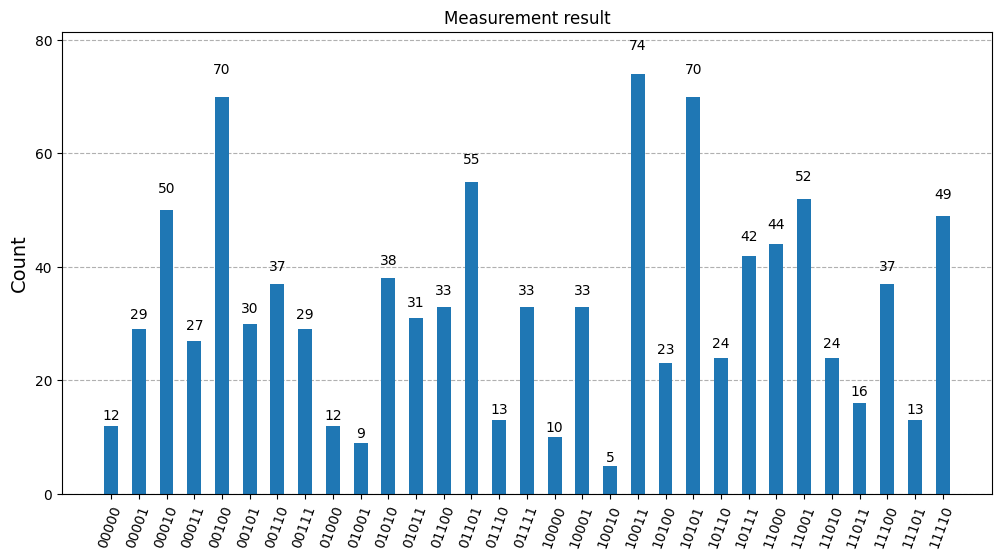

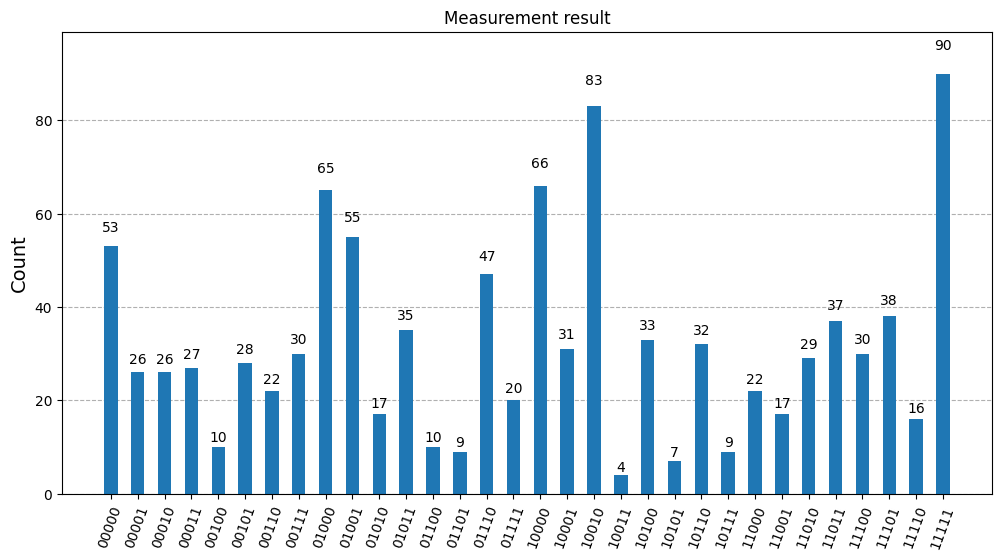

In [106]:
#display(final_circ[0].decompose().draw("mpl"))
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
#backend = BasicSimulator()

Meas_result = []
for i in range(len(final_circ)):
    final_circ[i].measure_all()
    simulator = AerSimulator()
    circ = transpile(final_circ[i], simulator)
    #print(circ.depth())
    # Run and get counts
    result = simulator.run(circ).result()
    
    counts = result.get_counts(circ)
    Meas_result.append(counts)
    display(plot_histogram(counts, title='Measurement result'))

In [107]:
#final_circ[0].decompose().draw("mpl")

In [108]:
#print(Meas_result[0])

In [109]:
predict_classes = []
for i in range(len(Meas_result)):
    predict = np.zeros((N))
    for str in Meas_result[i]:
        predict[int(str,2)] = Meas_result[i][str] / 1024
    
        #print(int(str,2))
    print(predict)
    predict_classes.append(predict)


[0.01171875 0.02832031 0.04882812 0.02636719 0.06835938 0.02929688
 0.03613281 0.02832031 0.01171875 0.00878906 0.03710938 0.03027344
 0.03222656 0.05371094 0.01269531 0.03222656 0.00976562 0.03222656
 0.00488281 0.07226562 0.02246094 0.06835938 0.0234375  0.04101562
 0.04296875 0.05078125 0.0234375  0.015625   0.03613281 0.01269531
 0.04785156 0.        ]
[0.05175781 0.02539062 0.02539062 0.02636719 0.00976562 0.02734375
 0.02148438 0.02929688 0.06347656 0.05371094 0.01660156 0.03417969
 0.00976562 0.00878906 0.04589844 0.01953125 0.06445312 0.03027344
 0.08105469 0.00390625 0.03222656 0.00683594 0.03125    0.00878906
 0.02148438 0.01660156 0.02832031 0.03613281 0.02929688 0.03710938
 0.015625   0.08789062]


In [110]:
label_predict = np.zeros(N)
for i in range(N):
    if predict_classes[0][i] < predict_classes[1][i]:
        label_predict[i] = 6
    else:
        label_predict[i] = 5
print(label_predict)


[6. 5. 5. 5. 5. 5. 5. 6. 6. 6. 5. 6. 5. 5. 6. 5. 6. 5. 6. 5. 6. 5. 6. 5.
 5. 5. 6. 6. 5. 6. 5. 6.]


In [111]:
#accuracy
count = 0
for i in range(N):
    if label_predict[i] == label[i] or label_predict[i] == label[i]:
        count = count + 1

print(count / N)

0.59375
